# GAN using Fasion-MNIST Data
For this problem, you will train a Generative Adversarial Network (GAN) on
Fashion-MNIST dataset. ​Fashion-MNIST is a dataset of Zalando's article images
consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each
example is a 28x28 grayscale image, associated with a label from 10 classes. You can
find it here: ​https://www.tensorflow.org/datasets/catalog/fashion_mnist​. ​Your GAN will
try to generate images that look like those in the Fashion-MNIST dataset.

### - Train a basic GAN that can generate images from the Fashion-MNIST dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.optimizers import Adam

In [2]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize pixel values to the range [-1, 1]
train_images = (train_images.astype("float32") - 127.5) / 127.5

# Reshape and expand dimensions for compatibility with convolutional layers
train_images = np.expand_dims(train_images, axis=-1)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(256)

4422102/4422102 [==============================] - 1s 0us/step


In [18]:
latent_dim = 128

# Build the Generator model
from tensorflow.keras.layers import Dense, Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape

# Generator model
def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_dim=latent_dim))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model


# Build the Discriminator model
from tensorflow.keras.layers import Conv2D, Dropout, Flatten

def make_discriminator_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model


generator = make_generator_model()
discriminator = make_discriminator_model()

In [19]:
# Optimizers with different learning rates
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Learning Rate Scheduler
def generator_lr_schedule(epoch):
    if epoch < 50:
        return 0.0002
    else:
        return 0.0002 * tf.math.exp(0.1 * (50 - epoch))

def discriminator_lr_schedule(epoch):
    if epoch < 50:
        return 0.0002
    else:
        return 0.0002 * tf.math.exp(0.1 * (50 - epoch))

gen_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(generator_lr_schedule)
disc_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(discriminator_lr_schedule)

# Loss function - Using Binary Crossentropy as an example
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [20]:
# Define the training loop functions and a function to show generated examples
@tf.function
def train_step(real_images):
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def train_gan(generator, discriminator, train_dataset, epochs, latent_dim):
    losses = {"generator": [], "discriminator": []}
    sample_intervals = [1, epochs // 2, epochs]  # Define the epochs for sampling

    for epoch in range(epochs):
        gen_lr = generator_lr_schedule(epoch)
        disc_lr = discriminator_lr_schedule(epoch)
        tf.keras.backend.set_value(generator_optimizer.lr, gen_lr)
        tf.keras.backend.set_value(discriminator_optimizer.lr, disc_lr)
        epoch_gen_loss = []
        epoch_disc_loss = []

        for image_batch in train_dataset:
            gen_loss, disc_loss = train_step(image_batch)
            epoch_gen_loss.append(gen_loss)
            epoch_disc_loss.append(disc_loss)

        losses["generator"].append(np.mean(epoch_gen_loss))
        losses["discriminator"].append(np.mean(epoch_disc_loss))

        if epoch + 1 in sample_intervals:
            generate_and_show_images(generator, epoch + 1, latent_dim)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}, Generator Loss: {losses['generator'][-1]}, Discriminator Loss: {losses['discriminator'][-1]}")

    return losses

def generate_and_show_images(generator, epoch, latent_dim):
    num_examples = 16
    random_noise = tf.random.normal([num_examples, latent_dim])
    generated_images = generator(random_noise, training=False)
    generated_images = (generated_images * 127.5 + 127.5).numpy().astype(int)

    fig = plt.figure(figsize=(4, 4))
    for i in range(num_examples):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')

    if epoch == 1:
      plt.suptitle("Generated Samples - Beginning of Training")
    elif epoch == epochs // 2:
      plt.suptitle("Generated Samples - 50% of Training")
    else:
      plt.suptitle("Generated Samples - After Convergence")

    plt.show()

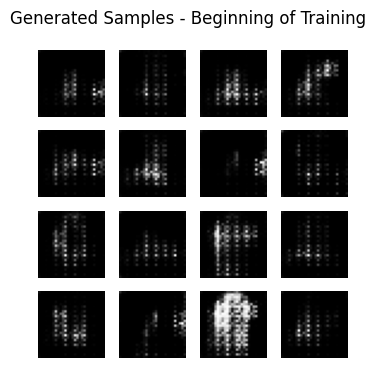

Epoch 10, Generator Loss: 1.2289543151855469, Discriminator Loss: 1.0218864679336548
Epoch 20, Generator Loss: 1.058632731437683, Discriminator Loss: 1.1277388334274292
Epoch 30, Generator Loss: 1.0510883331298828, Discriminator Loss: 1.1412254571914673
Epoch 40, Generator Loss: 1.0701026916503906, Discriminator Loss: 1.1308488845825195


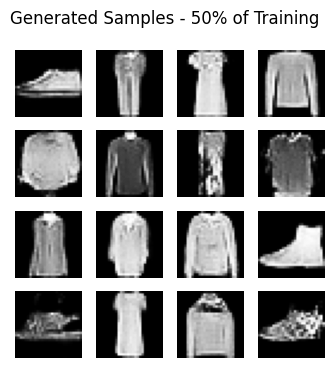

Epoch 50, Generator Loss: 1.0897362232208252, Discriminator Loss: 1.1293050050735474
Epoch 60, Generator Loss: 1.0154216289520264, Discriminator Loss: 1.1629844903945923
Epoch 70, Generator Loss: 0.9918957352638245, Discriminator Loss: 1.1727372407913208
Epoch 80, Generator Loss: 0.9785041809082031, Discriminator Loss: 1.1825717687606812
Epoch 90, Generator Loss: 0.9769662618637085, Discriminator Loss: 1.183280348777771


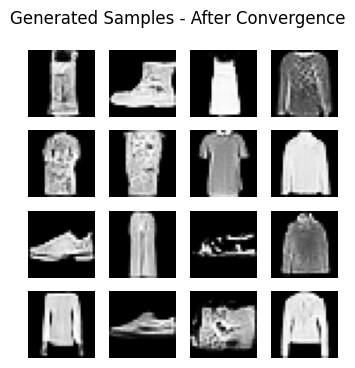

Epoch 100, Generator Loss: 0.9738556146621704, Discriminator Loss: 1.187690258026123


In [21]:
# Train the models and show generated sample from G in
# 1) the beginning of the training; 2) intermediate stage of the training, and 3) after converg
epochs = 100
losses = train_gan(generator, discriminator, train_dataset, epochs, latent_dim)

### - Plot the training loss curves for your G and D.

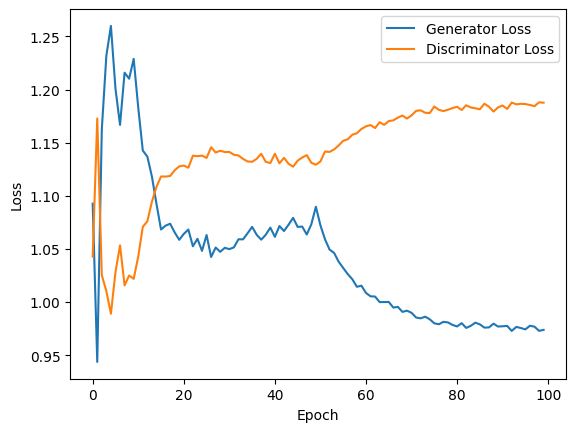

In [23]:
plt.plot(losses["generator"], label="Generator Loss")
plt.plot(losses["discriminator"], label="Discriminator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()